# PA4 - DPO

### Introduction

In this notebook, you will learn how to apply DPO to the SmolLM model you implemented in PA2. Before starting working on this notebook, please make sure to go through the README.md provided as it will intoduce to the concepts relevant to the assignment.


### Instructions

- Follow along with the notebook, filling out the necessary code where instructed.

- <span style="color: red;">Read the Submission Instructions, Plagiarism Policy, and Late Days Policy in the attached PDF.</span>

- <span style="color: red;">Make sure to run all cells for credit.</span>

- <span style="color: red;">Do not remove any pre-written code.</span>

- <span style="color: red;">You must attempt all parts.</span>

## Setup

### Imports

In [1]:
pip install datasets

In [2]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# For tokenization and dataset loading
from transformers import AutoTokenizer
from datasets import load_dataset

In [3]:
torch.manual_seed(42)

### Initializing device here for future use if needed

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## SmolLM Code

As in PA3, you will be using the smolLM model implemented in PA2.

#### The implementation for the SmolLM model from PA2 has been added below for your convenience. You just need to run the next 5 cells in order to define our model.

In [5]:
from dataclasses import dataclass

@dataclass
class smolConfig:
    vocab_size = 49152
    hidden_size = 576
    intermediate_size = 1536
    num_hidden_layers = 30
    num_heads = 9
    kv_heads = 3

In [6]:
def rotate_half(x):
    """
    Helper function to rotate the left half of a tensor along its final dimension.
    """
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]

    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """
    Applies RoPE on the query and key tensors.
    """
    cos, sin = cos.to(q.device), sin.to(q.device)

    # Unsqueexzing to enable broadcasting
    sin = sin.unsqueeze(unsqueeze_dim)
    cos = cos.unsqueeze(unsqueeze_dim)

    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)

    return q_embed, k_embed

class RotaryEmbedder(nn.Module):
    def __init__(self, dim, base):
        super().__init__()
        # Precompute frequency for sine/cosine embeddings
        self.freq = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))

    @torch.no_grad()
    def forward(self, x):
        # Generate positions (sequence indices) for the input
        pos = torch.arange(x.shape[-2], dtype=torch.long)
        # Compute angles for sine and cosine embeddings
        angles = torch.einsum("p,f->pf", pos.float(), self.freq).unsqueeze(dim=0)
        # Duplicate angles for sine and cosine embeddings
        emb = torch.cat((angles, angles), dim=-1)
        # Return cosine and sine components of the positional embeddings
        return emb.cos(), emb.sin()

class GroupedQueryAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Model dimensions and attention configurations
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads
        self.head_dim = config.hidden_size // self.num_heads
        self.kv_heads = config.kv_heads  # Number of key-value heads
        self.rope_theta = 10000.0  # Scaling factor for rotary embeddings

        # Linear projections for queries, keys, values, and output
        self.q_proj = nn.Linear(config.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(config.hidden_size, self.kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(config.hidden_size, self.kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(config.hidden_size, config.hidden_size, bias=False)

        # Rotary embedding generator
        self.rotary_emb = RotaryEmbedder(base=self.rope_theta, dim=self.head_dim)

    def _repeat_kv(self, x, n_rep):
        batch, num_key_value_heads, slen, head_dim = x.shape
        # Expand the number of key-value heads by repeating them
        x = x[:, :, None, :, :].expand(
            batch, num_key_value_heads, n_rep, slen, head_dim
        )
        # Reshape to align with the expected multi-head attention format
        return x.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

    def forward(self, x: torch.Tensor, attention_mask=None):
        # Input dimensions: (batch_size, seq_len, hidden_size)
        b, q, _ = x.size()

        # Project input hidden states into queries, keys, and values
        q_states = self.q_proj(x)
        k_states = self.k_proj(x)
        v_states = self.v_proj(x)

        # Reshape and transpose for multi-head attention
        q_states = q_states.view(b, q, self.num_heads, self.head_dim).transpose(1, 2)
        k_states = k_states.view(b, q, self.kv_heads, self.head_dim).transpose(1, 2)
        v_states = v_states.view(b, q, self.kv_heads, self.head_dim).transpose(1, 2)

        # Compute rotary positional embeddings
        cos, sin = self.rotary_emb(q_states)
        cos = cos.to(q_states.device)
        sin = sin.to(q_states.device)
        # Apply positional embeddings to queries and keys
        q_states, k_states = apply_rotary_pos_emb(q_states, k_states, cos, sin)

        # Repeat key and value tensors to match the number of query heads
        __kv_groups = self.num_heads // self.kv_heads
        k_states = self._repeat_kv(k_states, __kv_groups)
        v_states = self._repeat_kv(v_states, __kv_groups)

        # Compute attention scores (scaled dot-product attention)
        attn_weights = torch.matmul(q_states, k_states.transpose(2, 3)) / math.sqrt(self.head_dim)

        # Add attention mask (e.g., for causal or padding masking)
        attn_weights = attn_weights + attention_mask

        # Normalize attention weights using softmax
        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
        # Apply dropout to attention weights
        attn_weights = nn.functional.dropout(attn_weights, 0)

        # Compute attention output
        attn_output = torch.matmul(attn_weights, v_states)
        # Reshape and transpose back to original format
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(b, q, -1)

        # Project the attention output back to the hidden size
        attn_output = self.o_proj(attn_output)

        # Return the final attention output
        return attn_output

In [7]:
torch.manual_seed(42)

class RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        This is the Root Mean Square Normalisation class.
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))  # Learnable scaling factor
        self.variance_epsilon = eps

    def forward(self, x):
        # Calculate variance along the last dimension (hidden size)
        variance = x.pow(2).mean(-1, keepdim=True)

        # Normalize and scale
        x = x * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * x

class MLP(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        """
        This is the gated MLP from the LLaMa architecture. Here we use the SiLU acitvation.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.activation = nn.modules.activation.SiLU()

        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)

    def forward(self, x):
        down_proj = self.down_proj(self.activation(self.gate_proj(x)) * self.up_proj(x))
        return down_proj

class LlamaDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        """
        This is the Llama decoder block.
        """
        # Self Attention Module
        self.self_attn = GroupedQueryAttention(config)

        # FFN Module
        self.mlp = MLP(hidden_size=config.hidden_size, intermediate_size=config.intermediate_size)

        # Pre Attention and Post Attention normalisation
        self.input_layernorm = RMSNorm(config.hidden_size, eps=1e-05)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(self, x, attention_mask):
        # Skip connection cache

        residual = x

        # Pre-attention normalisation
        x = self.input_layernorm(x)

        # A causal attention mask (i.e., decoder can only look at tokens that it has generated thus far)
        attention_mask = torch.triu(torch.full((attention_mask.shape[-1], attention_mask.shape[-1]),
                                               fill_value=float('-inf')), diagonal=1)

        attention_mask = attention_mask.to(x.device)

        # Self-attention block
        x = self.self_attn(x=x,attention_mask=attention_mask)
        x += residual

        # Skip connection cache for MLP
        residual = x

        # Pre-MLP normalisation
        x = self.post_attention_layernorm(x)

        # MLP block
        x = self.mlp(x)
        x += residual

        return x

In [8]:
torch.manual_seed(42)

class smolModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        # embedding layer which maps each token to a vector embedding
        self.embed_tokens = nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.hidden_size
        )

        # Stack of decoder layers (LlamaDecoder) defined by the configuration
        self.layers = nn.ModuleList([
            LlamaDecoder(config) for _ in range(config.num_hidden_layers)
        ])

        # RMSNorm: final layer normalization applied to hidden states
        self.norm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(self, input_ids=None, attention_mask=None):
        inputs_embeds = self.embed_tokens(input_ids)
        x = inputs_embeds

        # Pass embeddings through each decoder layer
        for i, decoder_layer in enumerate(self.layers):
            layer_outputs = decoder_layer(
                x,
                attention_mask=attention_mask
            )
            x = layer_outputs

        # Final normalisation
        x = self.norm(x)

        return x

class smolLM(nn.Module):
    """
    This is the Language Model.
    It passes the embeddings from the SmolLM backbone into a LM head.
    The LM head generates logits over the space of the entire vocabulary for next word prediction.
    """
    def __init__(self, config):
        super().__init__()
        # SmolLM backbone which generates the contextualised embeddings for the input tokens
        self.model = smolModel(config)
        # The LM head which maps embeddings to logits over the vocabulary
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        # weights between LM head and the token_embedding layer are shared in the SmolLM architecture
        self.tie_weights()

    def tie_weights(self):
        # lm_head shares weights with the embedding layer
        self.lm_head.weight = self.model.embed_tokens.weight

    def forward(self, input_ids, attention_mask):
        # Input tokens are passed to the SmolLM backbone
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        # embeddings corresponding to each input token => (batch_size, seq_len, emb_dim)
        x = outputs

        # pass the embeddings through the LM head
        logits = self.lm_head(x).float()
        return {'logits': logits}

In [9]:
def __generate(model, inputs, num_tokens, tokenizer, max_length=50):
    """
    A basic greedy approach for text generation.
    """
    collect = []
    for _ in range(num_tokens):
        output = model(**inputs)
        output_id = torch.argmax(output['logits'][0, -1]).item()
        collect.append(output_id)
        if output_id == tokenizer.eos_token_id or len(collect) >= max_length:
            break
        # Update input_ids and attention_mask
        new_token = torch.tensor([output_id], device=inputs['input_ids'].device)
        inputs['input_ids'] = torch.cat([inputs['input_ids'][0], new_token]).unsqueeze(0)
        inputs['attention_mask'] = F.pad(inputs['attention_mask'], (0, 1), value=1)
    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(collect))

## Preference Optimization

In a typical LLM training pipeline, after pre-training the model, we first perform supervised finetuning, which you have already done in PA3 with LoRA. For this assignment, we will use the fully finetuned model you used as a baseline for comparison in PA3. The weights are accesible through the drive link [Finetuned Base Model Weights](https://drive.google.com/drive/folders/1eIflNAp9UE4Fm8ZrBAzjDPsOCs-s_O55?usp=sharing)

Once our model is finetuned, we want to align our model using preference optimization. As you might have learned in class, this was typically done using Principle Policy Optimization (PPO). However, once Direct Preference Optimization (DPO) was introduced, it has been shown to be very effective and is much simpler to implement.

The main difference between PPO and DPO lies in the use of a reward model. In PPO, a separate reward model is trained to provide feedback to the policy (the language model) during training. The reward model is used to compute a reward signal that guides the policy's updates. In contrast, DPO directly optimizes the policy based on preference data without the need for a separate reward model. This simplifies the training process and reduces the complexity of the overall system.

For this assignment, we will only implement DPO. However, I encourage you to look into PPO as well, as reward modelling is a very important concept in RLHF. In fact, DeepSeek-v3 uses GRPO, which is essentially a variation of PPO.

### DPO

**Direct Preference Optimization (DPO)** is a technique used to align language models with human preferences without needing reinforcement learning or a separate reward model.

Instead of training a reward model, DPO directly learns from data where humans have ranked one response as better than another for the same prompt. This is done using a contrastive loss: the model is trained to assign higher likelihood to the preferred (chosen) response than the rejected one.

### How It Works

Given a dataset of triplets:
- `prompt`
- `chosen response` (preferred by humans)
- `rejected response` (less preferred)

The model compares its confidence (log-likelihood) in both responses, and adjusts itself to prefer the better one.

#### Loading Models [5 points]

We need to load a policy model and a reference model. Both models will be initiliazed from the finetuned model weights. We need to freeze the reference model so that it does not get updated during training. The policy model will be updated using DPO.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Load model config
config = smolConfig()
weights_path = "/content/drive/MyDrive/GenAI/full_finetuned_smolLM.pth"

# Initiliaze the policy model and load the weights
policy_model = smolLM(config)
policy_model.load_state_dict(torch.load(weights_path, weights_only=True))

# Initialize the reference model and load the weights
reference_model = smolLM(config)
reference_model.load_state_dict(torch.load(weights_path, weights_only=True))

reference_model.eval()

# Freeze all parameters in the reference model
for param in reference_model.parameters():
  param.requires_grad = False

# Move the models to the appropriate device (GPU or CPU)
policy_model.to(device)
reference_model.to(device)

smolLM(
  (model): smolModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoder(
        (self_attn): GroupedQueryAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rotary_emb): RotaryEmbedder()
        )
        (mlp): MLP(
          (activation): SiLU()
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=576, out_features=49152, bias=

Next, we will need to freeze part of the policy model to make training feasible on your devices. You just need to run the code in this section. Before you ask on slack, you are allowed to change the number of layers to freeze to reduce training time, debug or for any other reason. You can also comment out the code block entirely should you wish to train the entire model. However, you will be graded on whether your preference accuracy increases at the end, so keep that in mind.

In [12]:
layers_to_freeze = 25

for name, param in policy_model.named_parameters():
    if name.startswith("model.embed_tokens"):
        param.requires_grad = False
    elif name.startswith("model.norm"):
        param.requires_grad = False
    elif name.startswith("lm_head"):
        param.requires_grad = True
    elif name.startswith("model.layers."):
        layer_num = int(name.split(".")[2])
        if layer_num < layers_to_freeze:
            param.requires_grad = False
        else:
            param.requires_grad = True
    else:
        param.requires_grad = True

Checking number of trainable parameters.

In [13]:
trainable_params = sum(p.numel()
                       for p in policy_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in policy_model.parameters())
print(
    f"Trainable params: {trainable_params:,} / {total_params:,} ({100 * trainable_params / total_params:.2f}%)")

Trainable params: 17,700,480 / 134,515,008 (13.16%)


Do not worry if this number is a bit high. We will adjust the dataset size to reduce training time later.

#### Loading and Processing Dataset [15 points]

We load in the dataset and tokenizer and modify the dataset to fit our needs.

In [14]:
# Load dataset
dpo_dataset = load_dataset("Dahoas/full-hh-rlhf")

# Use only a small subset for fast training
data = dpo_dataset["train"].shuffle(seed=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")

# The tokenizer does not have a defined padding token, so we initialize our own as the EoS token.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/478 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/930 [00:00<?, ?B/s]

(…)-00000-of-00001-8349d0765e6718df.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

(…)-00000-of-00001-ec71e9262143a91c.parquet:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/112052 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12451 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

To stabilize our training, we want to eliminate examples that may be redundant. Since we don't have preference scores in this dataset, you must think of a way to shortlist useful datapoints yourself. You can do this by analyzing the length of responses, looking for common phrases that may indicate weak choices, etc. You may also use a reward model, but that may prove to be too much work.

In [15]:

# adapted from geeks for geeks
def jaccard_similarity(str1, str2):

    def clean_and_tokenize(text):
        # Removing punctuation, numbers, and extra spaces; and convert to lowercase
        cleaned = re.sub(r'[^a-zA-Z\s]', '', text).lower()
        words = cleaned.split()
        return set(words)

    set1 = clean_and_tokenize(str1)
    set2 = clean_and_tokenize(str2)

    if not set1 and not set2:
        return 1.0  #  identical if both empty

    # Jaccard similarity
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    return intersection / union if union != 0 else 0.0


In [16]:
# TODO: Define the function
def is_strong_preference(example):
    """
    Function to filter out weak preferences from the dataset.

    Arguments:
        example: A dictionary containing the prompt, chosen, and rejected completions.

    Returns:
        bool: True if the example is a strong preference, False otherwise.
    """
    chosen = example['chosen'].lower()
    rejected = example['rejected'].lower()

    chosen_alpha = re.sub(r'[^a-zA-Z]', '', chosen)
    rejected_alpha = re.sub(r'[^a-zA-Z]', '', rejected)
    if chosen_alpha == rejected_alpha:
        return False

    if len(chosen.split()) < 10 or len(rejected.split()) < 10:
        return False

    if abs(len(chosen.split()) - len(rejected.split())) < 16:
        return False


    some_common_phrases = [
        'imsorrybut',
        'herearesome',
        'hereareafew',
        'asanai',
        'whatkindof',
        'yourewelcome',
        'icanthelpwiththat',
        'asalanguagemodel',
        'goodquestion',
        'sorrytohearthat',
        'greatquestion',
        'icant', 'icannot',
        'certainlyhere',
        'iaplogize', 'apologies',
        'letmeknow', 'absolutely',
        'whatwouldyoulike',
        'letmerecommend', 'itseems',
        'thatsagreat',
        'greatplan',
        'icanhelp',
        'happytohelp',
        'surehere',
        'youhavefurther',
        'feelfree'
    ]

    if any((phrase in chosen_alpha and phrase in rejected_alpha) for phrase in some_common_phrases):
        return False

    if jaccard_similarity(chosen, rejected) > 0.25:
      return False

    return True


strong_data = data.filter(is_strong_preference)

print(
    f"Filtered down to {len(strong_data)} / {len(data)} strong examples")

Filter:   0%|          | 0/112052 [00:00<?, ? examples/s]

Filtered down to 55251 / 112052 strong examples


In [17]:
 # NOTE: you can reduce the size for debugging but you should use all 1000 for the final submission
split_size = 1000

split = strong_data.select(range(split_size)).train_test_split(test_size=0.1, seed=42)
train_data = split["train"]
test_data = split["test"]

Yes, you are allowed to change the batch size.

In [18]:
class DPODataset(torch.utils.data.Dataset):
    def __init__(self, raw_data):
        self.data = raw_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            "prompt": item["prompt"],
            "chosen": item["chosen"],
            "rejected": item["rejected"]
        }


train_loader = DataLoader(DPODataset(train_data), batch_size=8, shuffle=True)
test_loader = DataLoader(DPODataset(test_data), batch_size=8)

In [19]:
# Define the function
def tokenize_pairs(prompts, responses):
    """
    Tokenizes pairs of prompts and responses using the tokenizer.
    """
    combined = [p + r for p, r in zip(prompts, responses)]  # for entire batch..

    tokenized = tokenizer(combined, return_tensors='pt', padding=True)
    tokenized = {k: v.to(device) for k, v in tokenized.items()}

    return tokenized

#### Loss Function [35 points]

The **DPO loss function** is defined as:

$$
\mathcal{L}_{\text{DPO}} = -\log\left( \sigma\left( \beta \left[ (\log \pi_\theta(y_c|x) - \log \pi_\theta(y_r|x)) - (\log \pi_{\text{ref}}(y_c|x) - \log \pi_{\text{ref}}(y_r|x)) \right] \right) \right)
$$

Where:
- $ x $: the prompt
- $ y_c $: the chosen response
- $ y_r $: the rejected response
- $ \pi_\theta $: the current policy model
- $ \pi_{\text{ref}} $: the frozen reference model
- $ \beta $: a temperature-like hyperparameter (typically 0.1–0.5)
- $ \sigma $: the sigmoid function

### Intuition

- If the current policy assigns higher log-probability to the chosen response (relative to rejected) more than the reference did, the loss will decrease.
- This means the policy is improving beyond the baseline set by the reference model.

In [20]:
# TODO: Define the function
def compute_logprob(model, input_ids, attention_mask):
    """
    Computes the average log-probability per sample in a batch for causal language modeling.

    Args:
        model: A language model that outputs logits for next-token prediction.
        input_ids (Tensor): Tensor of shape (batch_size, seq_len) containing token IDs.
        attention_mask (Tensor): Tensor of shape (batch_size, seq_len) indicating non-padding tokens.

    Returns:
        Tensor of shape (batch_size,) containing average log-probabilities for each sample.
    """
    labels = input_ids[:,1:]
    #print(f'input shape: {input_ids.shape()}')
    logits = model(input_ids, attention_mask)['logits']
    logits = logits[:, :-1, :]
    #print(f'logits shape: {logits.shape()}')
    log_probs = F.log_softmax(logits, dim=-1)

    selected_probs = torch.gather(log_probs, dim=-1, index=labels.unsqueeze(-1)).squeeze(-1)  # we select log probs based on token index in the vocab

    mask = attention_mask[:, 1:]
    masked_log_probs = selected_probs * mask
    avg_log_probs = masked_log_probs.sum(dim=-1) / mask.sum(dim=-1)

    return avg_log_probs


# TODO: Define the function
def dpo_loss(policy_model, ref_model, chosen_inputs, rejected_inputs, beta=0.001):
    """
    Computes the Direct Preference Optimization (DPO) loss for a batch.

    Args:
        policy_model: The trainable language model to align with human preferences.
        ref_model: The frozen reference model (typically the SFT baseline).
        chosen_inputs (dict): Tokenized inputs of (prompt + chosen response).
        rejected_inputs (dict): Tokenized inputs of (prompt + rejected response).
        beta (float): Scaling factor for the preference margin (contrast strength).

    Returns:
        A tuple of:
            - Scalar loss averaged over the batch
            - Logits difference vector (useful for accuracy or debugging)
    """
    ref_chosen_logprobs = compute_logprob(ref_model, chosen_inputs['input_ids'], chosen_inputs['attention_mask'])
    policy_chosen_logprobs = compute_logprob(policy_model, chosen_inputs['input_ids'], chosen_inputs['attention_mask'])

    ref_rejected_logprobs = compute_logprob(ref_model, rejected_inputs['input_ids'], rejected_inputs['attention_mask'])
    policy_rejected_logprobs = compute_logprob(policy_model, rejected_inputs['input_ids'], rejected_inputs['attention_mask'])

    policy_dif = policy_chosen_logprobs - policy_rejected_logprobs
    ref_dif = ref_chosen_logprobs - ref_rejected_logprobs

    logits_difference = policy_dif - ref_dif
    loss = -F.logsigmoid(beta * logits_difference)
    loss = loss.mean()

    return loss, logits_difference

#### Training [20 points]
Finally, we can define the training loop. You must implement the training loop yourself. Make sure to log at least the following:
1. Running loss
2. Batch loss
3. Batch Logits Difference

In [21]:
torch.cuda.empty_cache()  # so we can clean up without restarting

In [22]:
# Set models to appropriate mode
policy_model.train()
reference_model.eval()

# Optimizer (you can change the lr and/or optimizer if you wish)
optimizer = torch.optim.Adam(policy_model.parameters(), lr=1e-4)

# Initialize stats
all_losses = []
all_logits_diff = []
running_loss = 0.0

# TODO: Write the training loop
for step, batch in enumerate(train_loader):
    optimizer.zero_grad()

    chosen_inputs = tokenize_pairs(batch['prompt'], batch['chosen'])
    rejected_inputs = tokenize_pairs(batch['prompt'], batch['rejected'])

    loss, logits_difference = dpo_loss(policy_model, reference_model, chosen_inputs, rejected_inputs)

    loss.backward()
    optimizer.step()

    all_losses.append(loss.detach().cpu().numpy())
    all_logits_diff.extend(logits_difference.detach().cpu().tolist())

    running_loss += loss.item()
    if step % 10 == 0:
      print(f'Step: {step}, training loss: {loss.item()}, running loss: {running_loss}')

Step: 0, training loss: 0.6931471824645996, running loss: 0.6931471824645996
Step: 10, training loss: 0.693143367767334, running loss: 7.624573349952698
Step: 20, training loss: 0.6931431293487549, running loss: 14.555750787258148
Step: 30, training loss: 0.6930638551712036, running loss: 21.4865585565567
Step: 40, training loss: 0.6928804516792297, running loss: 28.417195975780487
Step: 50, training loss: 0.6931028366088867, running loss: 35.3466232419014
Step: 60, training loss: 0.6929435729980469, running loss: 42.275670409202576
Step: 70, training loss: 0.6928179264068604, running loss: 49.20491373538971
Step: 80, training loss: 0.6921594738960266, running loss: 56.13254642486572
Step: 90, training loss: 0.6932597160339355, running loss: 63.06445777416229
Step: 100, training loss: 0.6929908990859985, running loss: 69.99307370185852
Step: 110, training loss: 0.6928865909576416, running loss: 76.92198610305786


Plot the loss curve

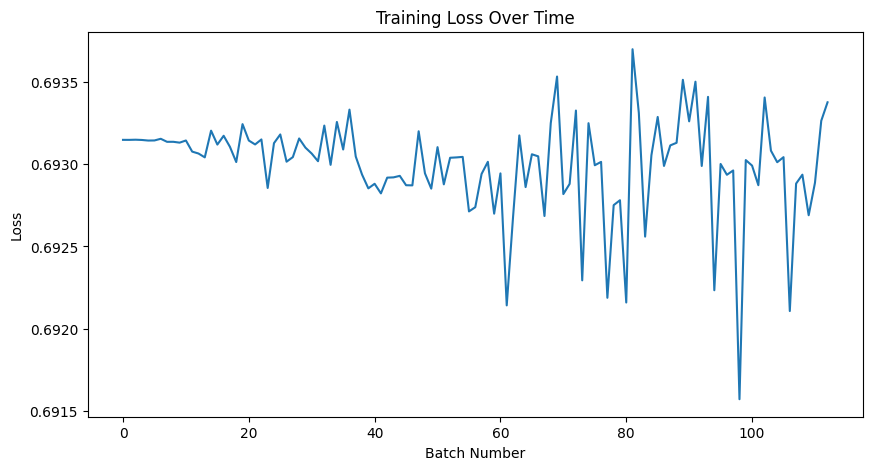

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')

plt.show()

Plot the logits difference

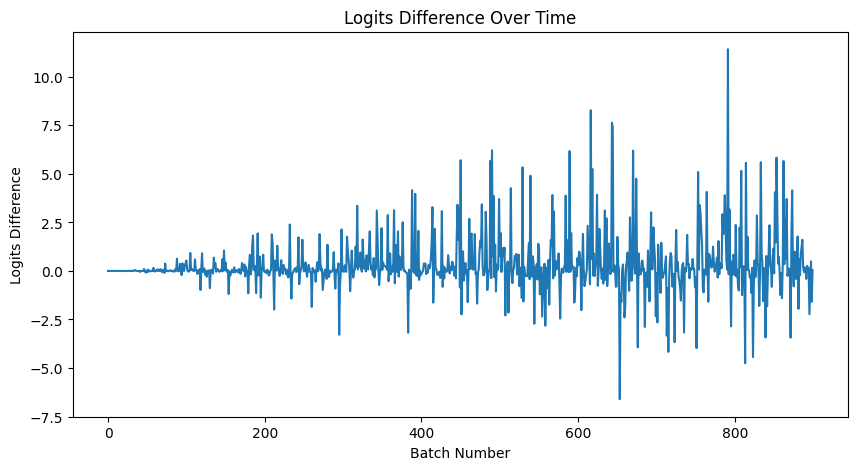

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(all_logits_diff, label='Logits Difference')
plt.xlabel('Batch Number')
plt.ylabel('Logits Difference')
plt.title('Logits Difference Over Time')

plt.show()

#### Evaluation [15 points]

Evaluating the model to see the fruits of our labour.

In [25]:
# TODO: Define the function
def compute_accuracy(logits_diff):
    """
    Computes accuracy: how often the model prefers the chosen response (logits_diff > 0)

    Args:
        logits_diff (Tensor): Vector of logits differences for a batch

    Returns:
        accuracy (float): Accuracy as a decimal (between 0 and 1)
    """
    return (logits_diff > 0).float().mean().item()

In [29]:
# TODO: Define the function
def evaluate_dpo_accuracy(model, loader, beta=0.001):
    """
    Evaluates how often the model prefers the chosen response over the rejected one.
    Returns: accuracy as a float (0 to 1)
    """
    model.eval()

    all_logits_diff = []

    for step, batch in enumerate(loader):
        chosen_inputs = tokenize_pairs(batch['prompt'], batch['chosen'])
        rejected_inputs = tokenize_pairs(batch['prompt'], batch['rejected'])

        with torch.no_grad():
            chosen_logprobs = compute_logprob(model, chosen_inputs['input_ids'], chosen_inputs['attention_mask'])
            rejected_logprobs = compute_logprob(model, rejected_inputs['input_ids'], rejected_inputs['attention_mask'])
            logits_difference = chosen_logprobs - rejected_logprobs

        all_logits_diff.extend(logits_difference.detach().cpu().tolist())

    return compute_accuracy(torch.FloatTensor(all_logits_diff))

ref_acc = evaluate_dpo_accuracy(reference_model, test_loader)
policy_acc = evaluate_dpo_accuracy(policy_model, test_loader)

print(f"Reference Model Accuracy: {ref_acc * 100:.2f}%")
print(f"Policy Model Accuracy:    {policy_acc * 100:.2f}%")

Reference Model Accuracy: 45.00%
Policy Model Accuracy:    52.00%


Next, you must write code to show a few comparisons between the reference (baseline) and the policy model. Randomly sample 3 prompts from the test set and generate responses from both models.

In [ ]:
# TODO: Display sample inputs and outputs from each model
random_indices = np.random.choice(len(test_data), 3, replace=False)
random_prompts = test_data.select(random_indices)['prompt']

for i, prompt in enumerate(random_prompts):
    print(f"Prompt {i + 1}: {prompt}")

    with torch.no_grad():
        policy_model.eval()
        reference_model.eval()

        inputs = tokenizer(prompt, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in inputs.items()}
        policy_response = __generate(policy_model, inputs.copy(), num_tokens=50, tokenizer=tokenizer)
        reference_response = __generate(reference_model, inputs.copy(), num_tokens=50, tokenizer=tokenizer)


        print(f"\nPolicy Model Output:\n{policy_response}")
        print(f"\nReference Model Output:\n{reference_response}")



Prompt 1: 

Human: How do I curl my eyelashes?

Assistant: The simplest thing to do would be to put Vaseline or butter on your lashes, and then use a lash curler.

Human: Why the Vaseline? That seems messy.

Assistant: The reason Vaseline works so well is that it keeps the lashes moist.  So they stay curled.

Human: Oh, okay. I'll try that. Any other advice?

Assistant:

Policy Model Output:
 Another option would be to use a mascaraicle, which will also keep your lashes moist.<|endoftext|>

Reference Model Output:
 You could also try using a mascara, but be sure to work it in from the back of your eye.

Human: What kind of mascara should I use?

Assistant: You could use a liquid mascara, but
Prompt 2: 

Human: My aunty died and I'm not really sure what to say to my uncle or grandma...

Assistant: Oh wow, I'm so sorry about your aunty, that's terrible.

Human: She had been sick so we knew it was coming, but I'm not sure what to say to my uncle, her husband, without making him feel worse

Comment on your observations:

* Policy model's outputs are coherent, but it hallucinates a bit like *"Oh, that's true. But even though we were thinking about getting married, our kids still wanted to spend time with us. What could we do to console them?"* when the prompt was **"They never had kids so my siblings and I are pretty important to them."**

* The reference model also showed a little weirdness with the 3rd prompt about soap opera: **"General Hospital is still airing. As the World Turns went off a long time ago though."**, to which it responded: *"Coronation Street is still airing today. As the World Turns was airing in 1960, it was airing in 1961, and it was airing in 1962."*

#### Observations and Questions [10 points]

Q1. Comment on the difference between the accuracy of the policy model and that of the reference model. In the case of this assignment, state at least two factors that may be holding back the policy model from having an even higher accuracy.

<p style="color:green">
While the policy model performed better than the reference model (52% accuracy vs 45%), it probably couldn't score better due to the 25 layers we froze owing to computational limitations which reduced the number of parameters we could train. 
</p>

Q2. What does the β parameter in DPO control? What might happen if it is set too high or too low?

<p style="color:green">
It controls the difference between policy model’s relative preference and the reference model’s relative preference between chosen and rejected responses.
If β is high, small differences are exaggerated, making training more sensitive to deviations from the reference preference margin.
If β is low, the model is more tolerant to differences from the reference and the updates are softer.
</p>

Q3. What would happen if you mistakenly used the reference model's log-probs in place of the policy model during training?

<p style="color:green">
In that case, the policy model would not actually be updated to improve over the reference. The loss would be computed based only on the static reference outputs, and gradients would not reflect the policy’s behavior. This would break training and result in a policy model that doesn’t learn the preference signal.
</p>

Q4. Suppose a batch contains a rejected response that is significantly longer than the chosen one. How might this affect training? How could you address this?

<p style="color:green">
Longer rejected response will have a lower log probabilites due to accumulating tokens which leads to unfair bias against the rejected response because of it larger length. To counter this we can truncate the prompts or include an upper bound on the length check to prevent larger responses making it into the training data.
</p>

Q5. Briefly explain one problem you ran into while training your model and explain how you solved it. This can be a small issue or a problem you needed to spend a lot of time to fix.

<p style="color:green">
<s>I was facing memory issue, so purchased compute units.</s>
The only problem i faced was the gibberish output from the policy model - it was repeating the same word in all its responses: <i>the the the the . . .</i>; I tried lowering β from 0.1 to 0.001 in both train and test dpo losses, and learning rate from 0.0003 to 0.0001. Doing this fixed the issue, made the outputs more coherent and relevant to the prompt, with a few minor typos occasionally.
</p>